In [1]:
!pip install fredapi

# Cell 1: Imports and API Setup
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from fredapi import Fred
from dotenv import load_dotenv

DATA_DIR = os.path.join('..', 'data')
START_DATE = '2009-01-01'

# Load API key from .env
load_dotenv(os.path.join('..', '.env'))
FRED_API_KEY = os.getenv('FRED_API_KEY')

if not FRED_API_KEY:
    raise ValueError('FRED_API_KEY not found in .env file. Add: FRED_API_KEY=your_key')

fred = Fred(api_key=FRED_API_KEY)
print('FRED API connected successfully.')
print(f'Data directory: {os.path.abspath(DATA_DIR)}')

  Using cached fredapi-0.5.2-py3-none-any.whl.metadata (5.0 kB)
Using cached fredapi-0.5.2-py3-none-any.whl (11 kB)



[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


FRED API connected successfully.
Data directory: c:\Users\chris\stock-prediction-ml\data


In [2]:
# Cell 2: Define Macro Indicators
INDICATORS = {
    'GS10': '10-Year Treasury Constant Maturity Rate (daily)',
    'VIXCLS': 'CBOE Volatility Index (daily)',
    'UNRATE': 'Unemployment Rate (monthly)',
    'GDP': 'Gross Domestic Product (quarterly)',
    'CPIAUCSL': 'Consumer Price Index (monthly)',
}

print('Indicators to download:')
for series_id, desc in INDICATORS.items():
    print(f'  {series_id}: {desc}')

Indicators to download:
  GS10: 10-Year Treasury Constant Maturity Rate (daily)
  VIXCLS: CBOE Volatility Index (daily)
  UNRATE: Unemployment Rate (monthly)
  GDP: Gross Domestic Product (quarterly)
  CPIAUCSL: Consumer Price Index (monthly)


In [3]:
# Cell 3: Download Macro Data
macro_data = {}

for series_id, desc in INDICATORS.items():
    try:
        data = fred.get_series(series_id, observation_start=START_DATE)
        data = data.dropna()
        macro_data[series_id] = data
        print(f'  {series_id}: {len(data)} observations ({data.index.min().strftime("%Y-%m-%d")} to {data.index.max().strftime("%Y-%m-%d")})')
    except Exception as e:
        print(f'  {series_id}: FAILED - {e}')

print(f'\nDownloaded {len(macro_data)}/{len(INDICATORS)} indicators')

if len(macro_data) < 3:
    raise ValueError('Insufficient macro data - check API key and network connection')

  GS10: 205 observations (2009-01-01 to 2026-01-01)
  VIXCLS: 4333 observations (2009-01-02 to 2026-02-12)
  UNRATE: 204 observations (2009-01-01 to 2026-01-01)
  GDP: 67 observations (2009-01-01 to 2025-07-01)
  CPIAUCSL: 204 observations (2009-01-01 to 2026-01-01)

Downloaded 5/5 indicators


In [4]:
# Cell 4: Forward-Fill to Daily Frequency
# Monthly/quarterly series need to be forward-filled so we can look up
# any date and get the most recent known value

macro_daily = {}

for series_id, data in macro_data.items():
    # Resample to daily and forward-fill
    daily = data.resample('D').ffill()
    macro_daily[series_id] = daily
    print(f'  {series_id}: {len(data)} raw -> {len(daily)} daily observations')

print(f'\nAll indicators resampled to daily frequency.')

  GS10: 205 raw -> 6210 daily observations
  VIXCLS: 4333 raw -> 6251 daily observations
  UNRATE: 204 raw -> 6210 daily observations
  GDP: 67 raw -> 6026 daily observations
  CPIAUCSL: 204 raw -> 6210 daily observations

All indicators resampled to daily frequency.


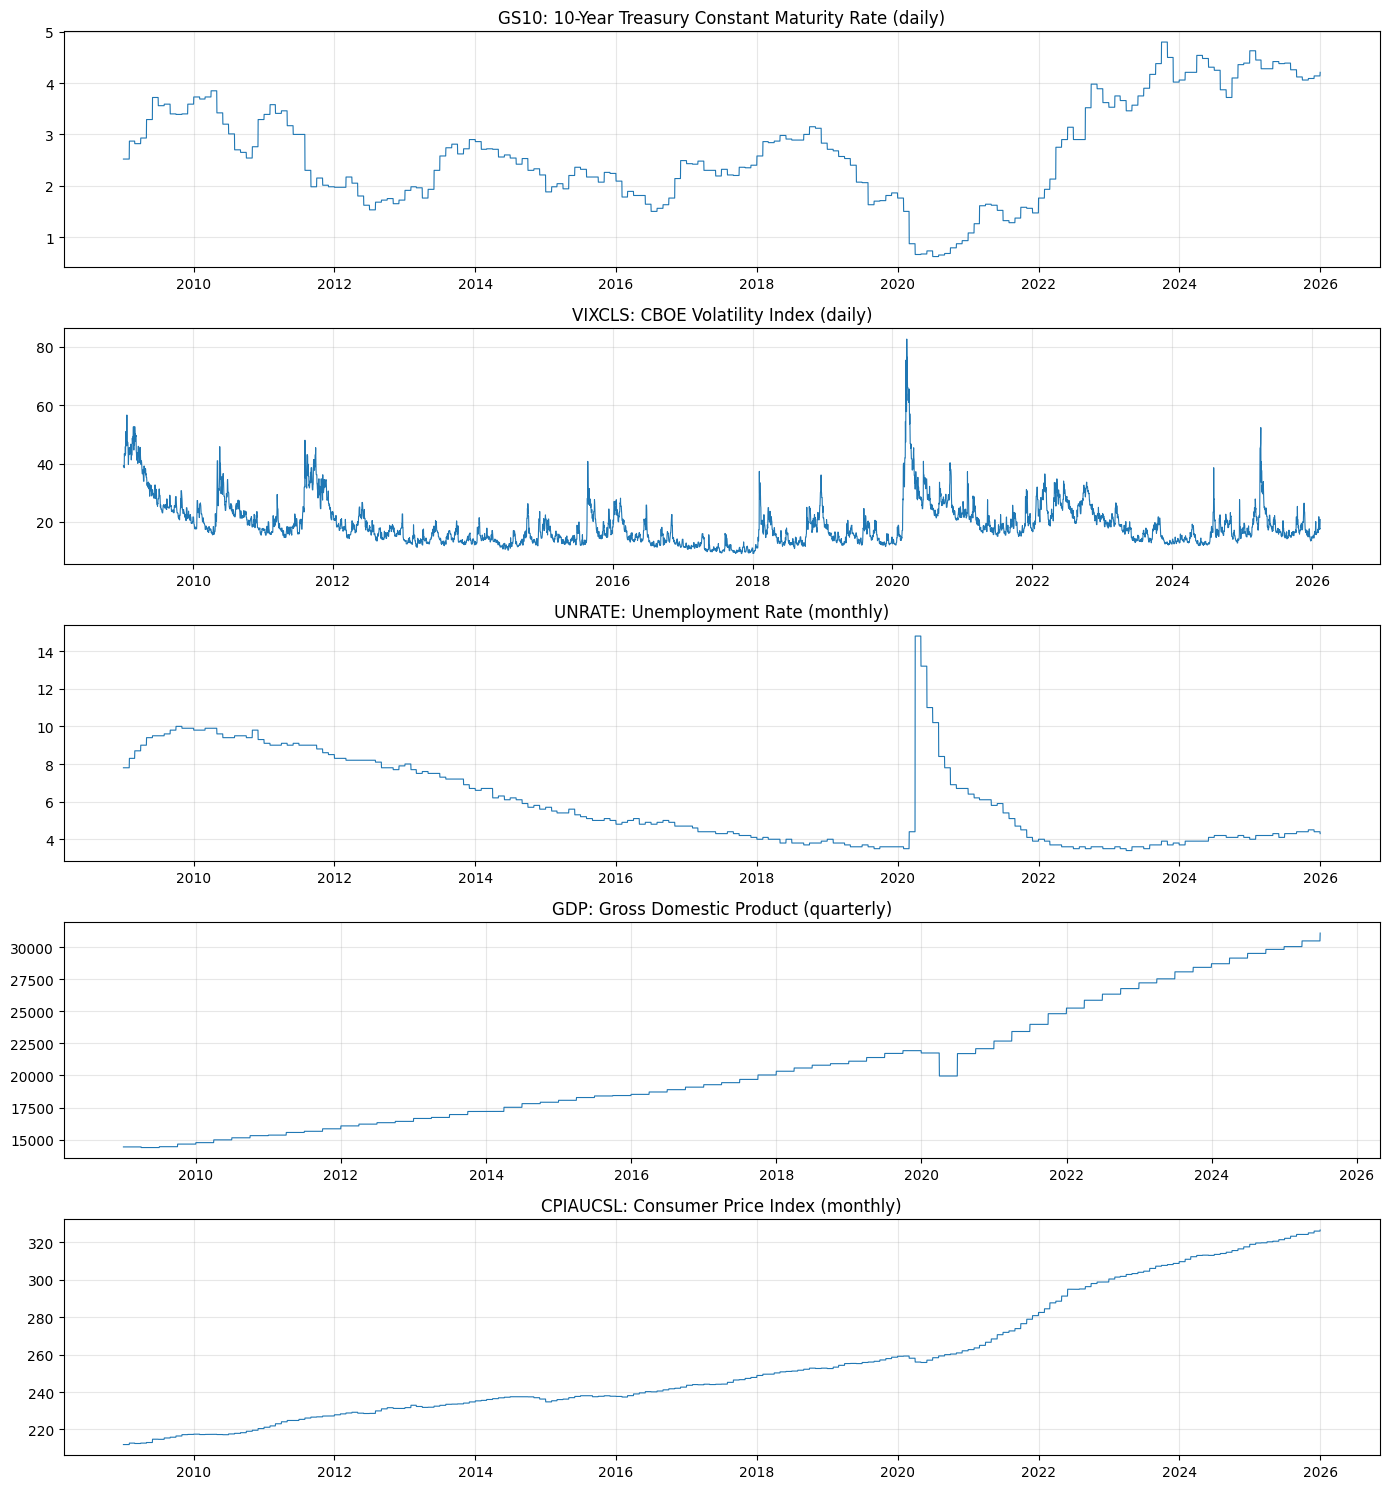

In [5]:
# Cell 5: Visualize Indicators
fig, axes = plt.subplots(len(macro_daily), 1, figsize=(14, 3 * len(macro_daily)))

for ax, (series_id, data) in zip(axes, macro_daily.items()):
    ax.plot(data.index, data.values, linewidth=0.8)
    ax.set_title(f'{series_id}: {INDICATORS[series_id]}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
# Cell 6: Save Macro Data
output_path = os.path.join(DATA_DIR, 'macro_data.pkl')
with open(output_path, 'wb') as f:
    pickle.dump(macro_daily, f)

print(f'Saved macro_data.pkl')
print(f'File size: {os.path.getsize(output_path) / 1024:.1f} KB')
print(f'Indicators: {list(macro_daily.keys())}')

# Show sample values
sample_date = pd.Timestamp('2020-03-15')  # COVID period
print(f'\nSample values at {sample_date.strftime("%Y-%m-%d")} (COVID):')
for series_id, data in macro_daily.items():
    val = data.asof(sample_date)
    print(f'  {series_id}: {val:.2f}')

Saved macro_data.pkl
File size: 727.0 KB
Indicators: ['GS10', 'VIXCLS', 'UNRATE', 'GDP', 'CPIAUCSL']

Sample values at 2020-03-15 (COVID):
  GS10: 0.87
  VIXCLS: 57.83
  UNRATE: 4.40
  GDP: 21751.24
  CPIAUCSL: 258.08


In [7]:
# Cell 7: Verification
with open(os.path.join(DATA_DIR, 'macro_data.pkl'), 'rb') as f:
    loaded = pickle.load(f)

assert isinstance(loaded, dict), 'Expected dict'
for series_id, data in loaded.items():
    assert isinstance(data, pd.Series), f'{series_id}: Expected Series'
    assert isinstance(data.index, pd.DatetimeIndex), f'{series_id}: Expected DatetimeIndex'

print('Verification passed!')
print(f'  Indicators: {len(loaded)}')
print(f'  Format: Dict[str, pd.Series]')
print(f'  Series IDs: {list(loaded.keys())}')
print(f'\nReady for notebook 02.')

Verification passed!
  Indicators: 5
  Format: Dict[str, pd.Series]
  Series IDs: ['GS10', 'VIXCLS', 'UNRATE', 'GDP', 'CPIAUCSL']

Ready for notebook 02.
